# Latent components (symmetry)

We would like to evaluate what the best method of identifying latent components is, between:

- Components with different IG and AP scores in the same direction (proxy latent components)
- Components with high IG symmetry (removing noise from the complete circuit)

### Set up

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import Tensor
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_device

from attribution_methods import integrated_gradients, activation_patching, highlight_components, asymmetry_score
from testing import Task, TaskDataset, logit_diff_metric, average_correlation, measure_overlap, test_multi_ablated_performance
from plotting import plot_attn, plot_attn_comparison, plot_correlation, plot_correlation_comparison, plot_bar_chart

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)
torch.cuda.empty_cache()

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


In [3]:
ig_corrupt_clean_mlp = torch.load("results/latent_components/ioi/ig_corrupt_clean_mlp.pt")
ap_corrupt_clean_mlp = torch.load("results/latent_components/ioi/ap_corrupt_clean_mlp.pt")

ig_corrupt_clean_attn = torch.load("results/latent_components/ioi/ig_corrupt_clean_attn.pt")
ap_corrupt_clean_attn = torch.load("results/latent_components/ioi/ap_corrupt_clean_attn.pt")

ig_clean_corrupt_mlp = torch.load("results/latent_components/ioi/ig_clean_corrupt_mlp.pt")
ap_clean_corrupt_mlp = torch.load("results/latent_components/ioi/ap_clean_corrupt_mlp.pt")

ig_clean_corrupt_attn = torch.load("results/latent_components/ioi/ig_clean_corrupt_attn.pt")
ap_clean_corrupt_attn = torch.load("results/latent_components/ioi/ap_clean_corrupt_attn.pt")

## Identifying latent components

In [6]:
# Latent components are those which have high AP asymmetry

ap_mlp_asymmetry = asymmetry_score(ap_corrupt_clean_mlp, ap_clean_corrupt_mlp, is_ig=False)
ap_attn_asymmetry = asymmetry_score(ap_corrupt_clean_attn, ap_clean_corrupt_attn, is_ig=False)

true_latent_mlp, true_latent_mlp_indices = highlight_components(ap_mlp_asymmetry)
true_latent_attn, true_latent_attn_indices = highlight_components(ap_attn_asymmetry)

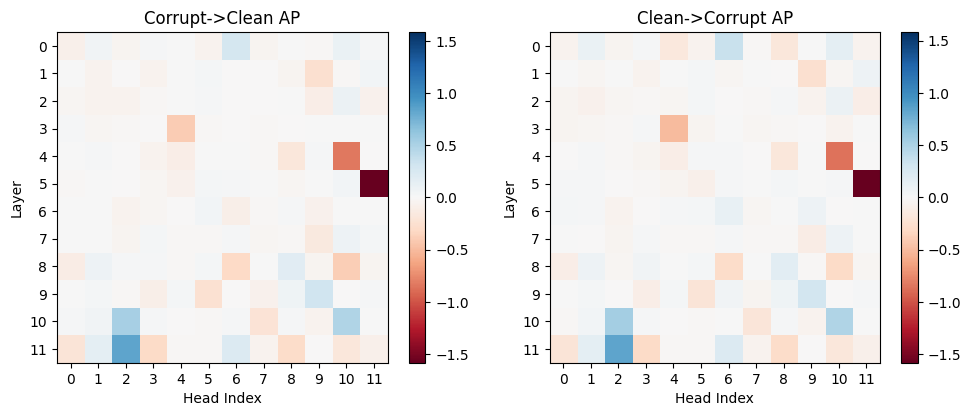

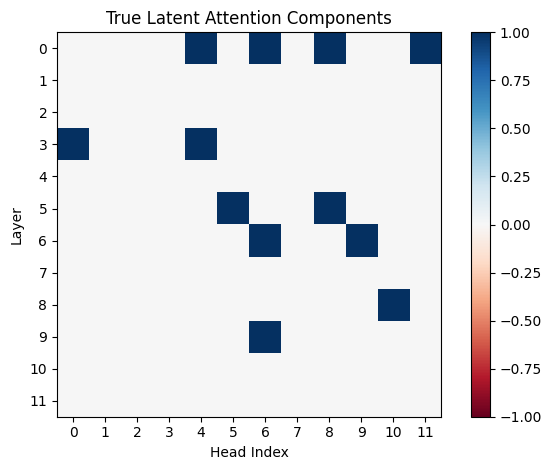

In [13]:
# Example of true latent attention components

plot_attn_comparison(ap_corrupt_clean_attn[:1], ap_clean_corrupt_attn[:1], model, "Corrupt->Clean AP", "Clean->Corrupt AP")

plot_attn(true_latent_attn[0].int(), model, title="True Latent Attention Components")

## Identify complete circuit

In [29]:
def abs_max_tensors(x, y):
    """Get the union of two tensors, taking the value with greater magnitude."""
    mins = torch.max(torch.abs(x), torch.abs(y))

    xSigns = (mins == torch.abs(x)) * torch.sign(x)
    ySigns = (mins == torch.abs(y)) * torch.sign(y)
    finalSigns = xSigns.int() | ySigns.int()

    return mins * finalSigns

In [33]:
# Union of components with high AP scores in each direction
max_attn = abs_max_tensors(ap_corrupt_clean_attn, ap_clean_corrupt_attn)
max_mlp = abs_max_tensors(ap_corrupt_clean_mlp, ap_clean_corrupt_mlp)

complete_attn = highlight_components(max_attn, 0.8)[0]
complete_mlp = highlight_components(max_mlp, 0.8)[0]

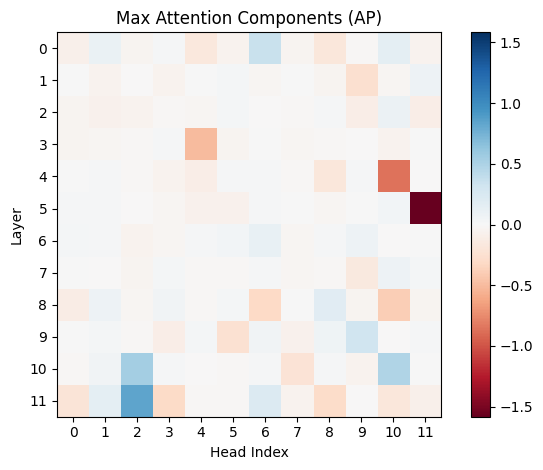

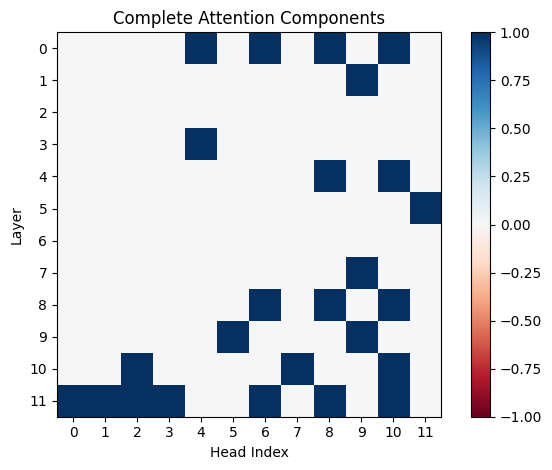

In [34]:
plot_attn(max_attn[0], model, title="Max Attention Components (AP)")
plot_attn(complete_attn[0].int(), model, title="Complete Attention Components")